<h1>Data Preprocess</h1>

Import the libraries that we will use in this script.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

Read in train and test data set.

In [2]:
train = pd.read_excel('C:/Users/BenBen Chen/Python Practice/Project_Big market predict/train.xlsx')
test = pd.read_excel('C:/Users/BenBen Chen/Python Practice/Project_Big market predict/test.xlsx')

In [3]:
#concatenate the train data and test data, and add 'source' column as tag to differentiate two source  
train['source'] = 'train'
test['source'] = 'test'
concat_data = pd.concat([train, test], ignore_index=True, sort=True)

In [4]:
concat_data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


<h2>Data Exploration</h2>

First, we take a look if there are any missing value in each column, also the unique value of each column.

In [5]:
#check missing value and unique value of each column
print('Missing value in each column:\n', concat_data.apply
      (lambda x: sum(x.isnull()), axis=0), '\n\n')
print('Unique value in each column:\n', concat_data.apply
      (lambda x: len(x.unique()), axis=0), '\n\n')

Missing value in each column:
 Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64 


Unique value in each column:
 Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64 




At this point, we can find three columns have missing value, we leave Item_Outlet_Sales as it, because these missing value come from test data set, but Item_Weight and Outlet_Size we need to do some improvement later.
Also take look at the unique value in each column, we will know there are 1559 products and 10 outlets in this data set, and our goal is predicting the sales for any combination of them.

Now we explore the content of categorical columns. 

In [6]:
categorical_col = [x for x in concat_data.columns if concat_data.dtypes[x] == 'object'
                 and x not in ['Item_Identifier','Outlet_Identifier','source']]

for col in categorical_col:
    print('Frequency of categories %s'%col)
    print(concat_data[col].value_counts(), '\n\n')

Frequency of categories Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64 


Frequency of categories Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64 


Frequency of categories Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64 


Frequency of categories Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64 


Frequency of categories Outlet_Type
Superm

Item_Fat_Content has 5 categories, and we can see 'Low Fat', 'LF', 'low fat' are duplicated, 'Regular' and 'reg' are also duplicated, we will deal with the problem later.

Now, we observe relationship between Item_Outlet_Sales and each categorical variable with box-chart. 

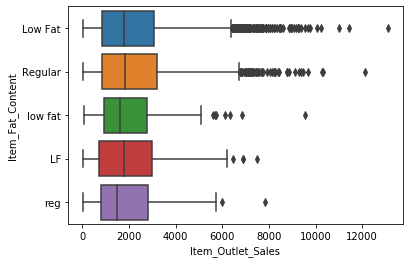

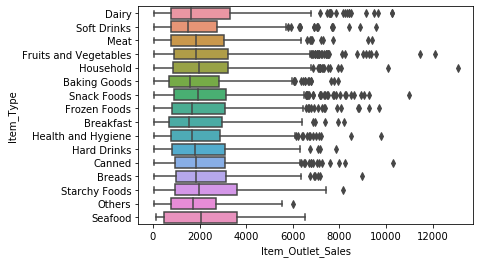

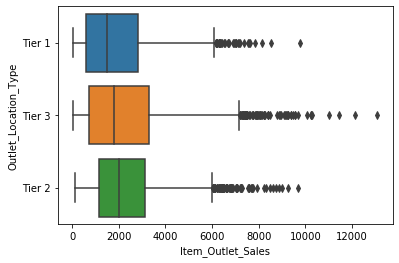

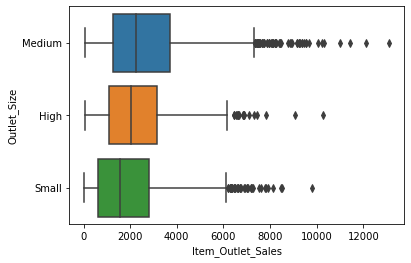

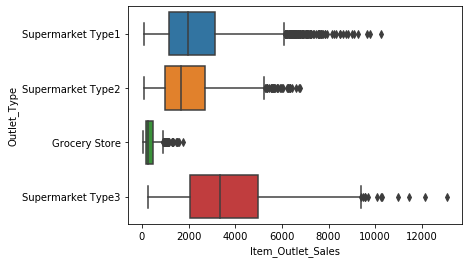

In [7]:
for col in categorical_col:
    seaborn.boxplot(x='Item_Outlet_Sales', y=col, data=train)
    plt.show()

According to these box plot above, we can find out that Outlet_Type and Outlet_Size may have some influences to our target varible Item_Outlet_Sales due to significant difference between categories. Item_Type has too many categories, seems not have much effects on our target variable, we will simplify categories in this feature.   

Now we explore the columns contiain numeric values. 

In [8]:
numeric_col = [x for x in concat_data.columns if concat_data.dtypes[x] != 'object'
                 and x not in ['Item_Identifier','Outlet_Identifier','source']]
df_numeric_col = train[numeric_col].copy()
df_numeric_col.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,7060.000000,8523.000000
mean,140.992782,2181.288914,0.066132,12.857645,1997.831867
std,62.275067,1706.499616,0.051598,4.643456,8.371760
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,93.826500,834.247400,0.026989,8.773750,1987.000000
50%,143.012800,1794.331000,0.053931,12.600000,1999.000000
75%,185.643700,3101.296400,0.094585,16.850000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


We can find Item_Visibility has minimum value is 0.00, it doesn't make sense, we will do some improvement later.
Furthermore, we can observe the correlation of Item_Outlet_Sales and other variables

In [9]:
df_numeric_col.corr()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
Item_MRP,1.000000,0.567574,-0.001315,0.027141,0.005020
Item_Outlet_Sales,0.567574,1.000000,-0.128625,0.014123,-0.049135
Item_Visibility,-0.001315,-0.128625,1.000000,-0.014048,-0.074834
Item_Weight,0.027141,0.014123,-0.014048,1.000000,-0.011588
Outlet_Establishment_Year,0.005020,-0.049135,-0.074834,-0.011588,1.000000


At this point, we can find Item_Outlet_Sales has a positive linear relationship with Item_MRP, let's plot a scatter for visualization.

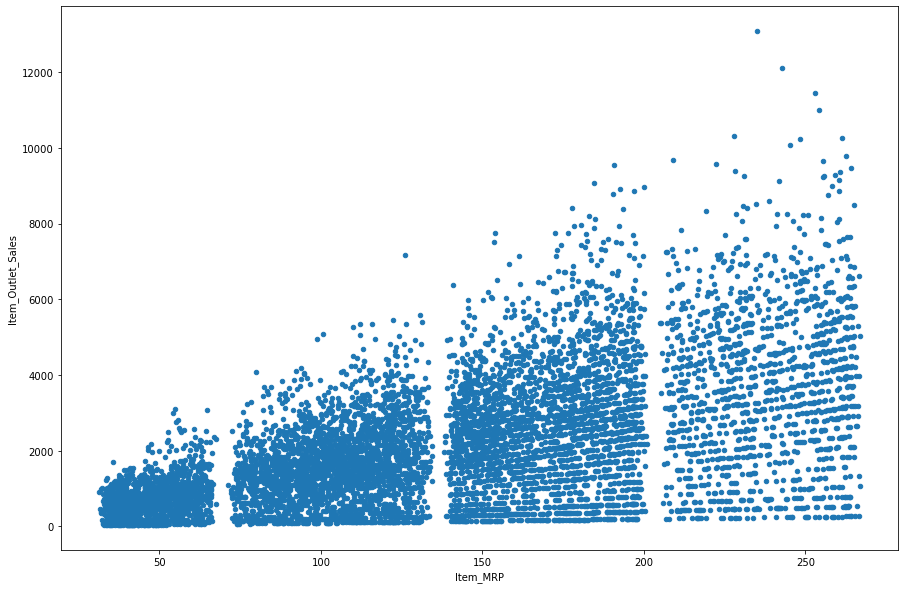

In [10]:
df_numeric_col[['Item_Outlet_Sales', 'Item_MRP']].plot(kind='scatter', x='Item_MRP', y='Item_Outlet_Sales',figsize=(15,10))

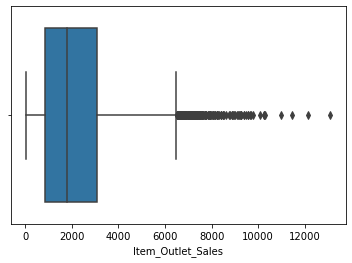

IQR of Item_Outlet_Sales:  2267.049 


Outlier of Item_Outlet_Sales: 
 False    8337
True      186
Name: Item_Outlet_Sales, dtype: int64 


Percent of Item_Outlet_Sales outlier:  2.1823301654347063


In [11]:
seaborn.boxplot(x='Item_Outlet_Sales', data=train)
plt.show()
train.shape[0]
Q1 = train['Item_Outlet_Sales'].quantile(0.25)
Q3 = train['Item_Outlet_Sales'].quantile(0.75)
IQR = Q3 - Q1
outlier_of_target_var = (train['Item_Outlet_Sales'] < (Q1 - 1.5 * IQR)) | (train['Item_Outlet_Sales'] > (Q3 + 1.5 * IQR))
print('IQR of Item_Outlet_Sales: ', IQR, '\n\n')
print("Outlier of Item_Outlet_Sales: \n", outlier_of_target_var.value_counts(), '\n\n')

percent_outlier = 100 * sum(outlier_of_target_var==True) / train.shape[0]
print('Percent of Item_Outlet_Sales outlier: ', percent_outlier)

We know outlier will impact machine learning modeling, special in linear regression, let's take a look at outlier of our target variable, above the code, we found there are 186 outliers in target variable, Item_Outlet_Sales. It's 2.18% amount of train data, we may consider to do some action to improve it, I leave this at the section of model evaluating. 

At the end of Data Exploration, here is our mini conclusion:
1. Categorical feature Outlet_Type and Outlet_Size have some influences to our target varible Item_Outlet_Sales.
2. Numeric feature Maximum retail price is a important factor to pridict sales, higher MRP, bigger chance to have higher sales. 
3. We found several problems, however we will fix them in later section of data cleaning and fearture engineering.

In [12]:
'''train['Item_MRP'].unique()
train.loc[train['Item_Identifier']=='FDG33', 'Outlet_Identifier']
train.loc[train['Item_Identifier']=='FDG33', 'Item_MRP'].mean()
mean_Item_MRP_gb_Item_ID = pd.pivot_table(index='Item_Identifier', values='Item_MRP', aggfunc='mean', data=train)
mean_Item_MRP_gb_Item_ID
train['mean_Item_MRP_by_Item_ID'] = train.apply\
(lambda x: x['Item_MRP']/mean_Item_MRP_gb_Item_ID.loc[x['Item_Identifier'], 'Item_MRP'], axis=1)
train['mean_Item_MRP_by_Item_ID']
train.plot(kind='scatter', x = 'mean_Item_MRP_by_Item_ID', y='Item_Outlet_Sales', figsize=(15,8))
'''

"train['Item_MRP'].unique()\ntrain.loc[train['Item_Identifier']=='FDG33', 'Outlet_Identifier']\ntrain.loc[train['Item_Identifier']=='FDG33', 'Item_MRP'].mean()\nmean_Item_MRP_gb_Item_ID = pd.pivot_table(index='Item_Identifier', values='Item_MRP', aggfunc='mean', data=train)\nmean_Item_MRP_gb_Item_ID\ntrain['mean_Item_MRP_by_Item_ID'] = train.apply(lambda x: x['Item_MRP']/mean_Item_MRP_gb_Item_ID.loc[x['Item_Identifier'], 'Item_MRP'], axis=1)\ntrain['mean_Item_MRP_by_Item_ID']\ntrain.plot(kind='scatter', x = 'mean_Item_MRP_by_Item_ID', y='Item_Outlet_Sales', figsize=(15,8))\n"

<h2>Data Cleaning</h2>

We take care about the problems that we found from data exploration, here are the problems relate to data cleaning
1. missing value in the column Item_Weight.
2. missing value in the column Outlet_Size.

Deal with Item_Weight, use the average weight grouped by Item_Identifier
to impute null value of Item_Weight

In [13]:
#get miss value in Item_Weight
missing_weight = concat_data['Item_Weight'].isnull()
avg_item_weight = concat_data.pivot_table\
                  (index='Item_Identifier', values='Item_Weight')

concat_data.loc[missing_weight, 'Item_Weight'] = \
            concat_data.loc[missing_weight, 'Item_Identifier'].apply\
            (lambda x: avg_item_weight.loc[x, 'Item_Weight'])

print('Missing value in Item_Weight: ',\
      sum(concat_data['Item_Weight'].isnull()), \
      '\n\n')

Missing value in Item_Weight:  0 




Deal with Outlet_Size, use mode number of Outlet_Size grouped by Outlet_Type to impute null value of Outlet_size

In [14]:
#Import mode function:
from scipy.stats import mode

#get miss value in Outlet_Size
missing_outlet_size = concat_data['Outlet_Size'].isnull()

mode_outlet_size = concat_data.pivot_table\
        (index='Outlet_Type', values='Outlet_Size', aggfunc=(lambda x:mode(x).mode[0]))


concat_data.loc[missing_outlet_size, 'Outlet_Size'] = \
        concat_data.loc[missing_outlet_size, 'Outlet_Type'].apply\
        (lambda x: mode_outlet_size.loc[x, 'Outlet_Size'])

print('Missing value in Outlet_Size: ',\
      sum(concat_data['Outlet_Size'].isnull()), '\n\n')
print('Missing value in each column:\n', concat_data.apply
      (lambda x: sum(x.isnull()), axis=0), '\n\n')

Missing value in Outlet_Size:  0 


Missing value in each column:
 Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
dtype: int64 




<h2>Data Engineering</h2>

We will solve the couple problems that we discovered from data exploration, here is the to-do list
1. Modify invalid zeros value in column Item_Visibility.
2. Combine the unnecessary categories of column Item_Type_Combined.
3. Duplicated value in column Item_Fat_Content.
4. Determine the operation years of stores from column Outlet_Establishment_Year.
5. Because scikit-learn only accepts numeric variables, convert the categorical variables to numeric variables.

In [15]:
#impute these Item_Visibility which are 0 with mean of Item_Visibility group by Item_Identifier
print('zero value of Item_Visibility before impute: ', sum(concat_data['Item_Visibility'] == 0), '\n\n')
mean_visibility_by_item_ID = concat_data.pivot_table\
                             (index='Item_Identifier', values='Item_Visibility')
missing_item_vb = (concat_data['Item_Visibility'] == 0.0)

concat_data.loc[missing_item_vb, 'Item_Visibility'] = concat_data.loc[missing_item_vb, 'Item_Identifier'].apply\
                                                      (lambda x: mean_visibility_by_item_ID.loc[x,'Item_Visibility'])
print('zero value of Item_Visibility after impute: ', sum(concat_data['Item_Visibility'] == 0), '\n\n')

zero value of Item_Visibility before impute:  879 


zero value of Item_Visibility after impute:  0 




In [16]:
#combine the categories, and create a new column Item_Type_Combined to store it
concat_data['Item_Type_Combined'] = concat_data['Item_Identifier'].apply(lambda x: x[0:2])
concat_data['Item_Type_Combined'] = concat_data['Item_Type_Combined'].map({'FD':'Food', 'NC':'Non-comsumable', 'DR':'Drinks'})
print('Frequency table of Item_Type_Combined: \n', concat_data['Item_Type_Combined'].value_counts(), '\n\n')

Frequency table of Item_Type_Combined: 
 Food              10201
Non-comsumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64 




In [17]:
#Modify categories of Item_Fat_Content
concat_data['Item_Fat_Content'] = concat_data['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'})
print('Frequency table Item_Fat_Content: \n', concat_data['Item_Fat_Content'].value_counts(), '\n\n')
#Non-comsumable item should not have fat content, modify it as Non-Edible
concat_data.loc[concat_data['Item_Type_Combined'] == 'Non-comsumable', 'Item_Fat_Content'] = 'Non-Edible'
print('Frequency table Item_Fat_Content: \n', concat_data['Item_Fat_Content'].value_counts(), '\n\n')

Frequency table Item_Fat_Content: 
 Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64 


Frequency table Item_Fat_Content: 
 Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64 




In [18]:
#determine the years of operation of stores 
concat_data['Operation_Years'] = concat_data['Outlet_Establishment_Year'].apply(lambda x: 2013-x)
print('Summary of Operation_Years', concat_data['Operation_Years'].describe(), '\n\n')

Summary of Operation_Years count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Operation_Years, dtype: float64 




In [19]:
#Because scikit-learn only accepts numeric variables, convert the nominal variable to numeric variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#create numeric version of column 'Outlet_Identifier', column 'Outlet' 
concat_data['Outlet'] = le.fit_transform(concat_data['Outlet_Identifier'])

#convert these catgorical columns to be numerical  
nominal_var_list = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type_Combined']

for i in nominal_var_list:
    print('Before transform: \n', concat_data[i].value_counts(),'\n\n')
    concat_data[i] = le.fit_transform(concat_data[i])
    print('After transform: \n', concat_data[i].value_counts(), '\n\n')

#use numerical columns to create one-hot-code data
concat_data = pd.get_dummies(concat_data, columns=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type',\
                                                   'Outlet_Type', 'Item_Type_Combined', 'Outlet'], dtype='int16')
print(concat_data.dtypes, '\n\n')
print("After one-hot-encode, Item_Fat_Content: \n", \
      concat_data[['Item_Fat_Content_0', 'Item_Fat_Content_1', 'Item_Fat_Content_2']].head(), '\n\n')

Before transform: 
 Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64 


After transform: 
 0    6499
2    5019
1    2686
Name: Item_Fat_Content, dtype: int64 


Before transform: 
 Small     7996
Medium    4655
High      1553
Name: Outlet_Size, dtype: int64 


After transform: 
 2    7996
1    4655
0    1553
Name: Outlet_Size, dtype: int64 


Before transform: 
 Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64 


After transform: 
 2    5583
1    4641
0    3980
Name: Outlet_Location_Type, dtype: int64 


Before transform: 
 Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64 


After transform: 
 1    9294
0    1805
3    1559
2    1546
Name: Outlet_Type, dtype: int64 


Before transform: 
 Food              10201
Non-comsumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64 


After transform: 
 1 

In [20]:
#drop useless columns
concat_data.drop(['Item_Type', 'Outlet_Establishment_Year'], axis=1, inplace=True)

#split data set back to train-set and test-set
train = concat_data.loc[concat_data['source'] == 'train', :].copy()
test = concat_data.loc[concat_data['source'] == 'test', :].copy()

train.drop(['source'], axis=1, inplace=True)
test.drop(['source', 'Item_Outlet_Sales'], axis=1, inplace=True)

In [21]:
train.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,Operation_Years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,0.016047,9.30,OUT049,14,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,0.019278,5.92,OUT018,4,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,0.016760,17.50,OUT049,14,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,0.017834,19.20,OUT010,15,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,53.8614,994.7052,0.009780,8.93,OUT013,26,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [22]:
test.head()

,Item_Identifier,Item_MRP,Item_Visibility,Item_Weight,Outlet_Identifier,Operation_Years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,Outlet_Size_0,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
8523,FDW58,107.8622,0.007565,20.750,OUT049,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8524,FDW14,87.3198,0.038428,8.300,OUT017,6,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
8525,NCN55,241.7538,0.099575,14.600,OUT010,15,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
8526,FDQ58,155.0340,0.015388,7.315,OUT017,6,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8527,FDY38,234.2300,0.118599,13.600,OUT027,28,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
#export data to excel file
#train.to_excel('train_optimized.xlsx', index=False)
#test.to_excel('test_optimized.xlsx', index=False)

At the end of feature engineering, we already get our data prepared, we can use the clean data to build the pridiction model. 